# Estimating uncertainties with PyCS3

<a href="mailto:martin.millon@epfl.ch">Martin Millon</a>, 05.2020

This notebook demonstrates how to estimate uncertainties with PyCS3. Please refer to [Tewes et al. 2013](https://arxiv.org/abs/1208.5598) and [Millon et al. 2020](https://arxiv.org/abs/2002.05736) for a detailed description. 

In [1]:
import numpy as np 
import os
import pycs3.gen.lc_func
import pycs3.spl.topopt
import pycs3.gen.mrg
import pycs3.gen.splml
import pycs3.regdiff.multiopt
import pycs3.regdiff.rslc
import pycs3.sim.draw 
import pycs3.sim.run
import pycs3.sim.plot
import pycs3.sim.twk
import pycs3.mltd.plot
import pycs3.mltd.comb

In [2]:
rdbfile = "data/trialcurves.txt"
simfolder = "./sim"

if not os.path.isdir(simfolder):
    os.mkdir(simfolder)

lcs = [
    pycs3.gen.lc_func.rdbimport(rdbfile, 'A', 'mag_A', 'magerr_A', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'B', 'mag_B', 'magerr_B', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'C', 'mag_C', 'magerr_C', "Trial"),
    pycs3.gen.lc_func.rdbimport(rdbfile, 'D', 'mag_D', 'magerr_D', "Trial")
]
pycs3.gen.mrg.colourise(lcs) # Gives each curve a different colour.

Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/A] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/B] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/C] with 192 points imported (0 of them masked).
Checking header of "trialcurves.txt"...
Reading "trialcurves.txt"...
[Trial/D] with 192 points imported (0 of them masked).


## Fit the model

We first need to choose the model parameters, check visually the fit and the save the optimised curves.

Wrote data/optcurves.pkl


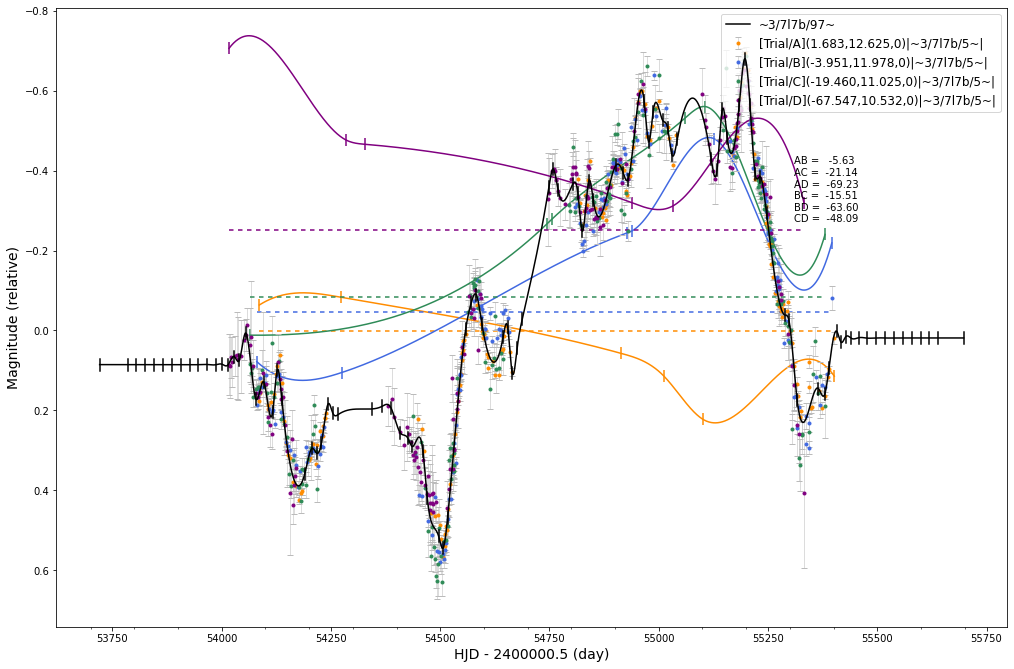

Time delays:
AB =   -5.63
AC =  -21.14
AD =  -69.23
BC =  -15.51
BD =  -63.60
CD =  -48.09


In [3]:
mlknotstep = 200
knotstep=20

def spl(lcs, kn=knotstep):
    spline = pycs3.spl.topopt.opt_fine(lcs, nit=5, knotstep=knotstep, verbose=False)
    return spline

def regdiff(lcs, **kwargs):
    return pycs3.regdiff.multiopt.opt_ts(lcs, pd=kwargs['pd'], covkernel=kwargs['covkernel'], pow=kwargs['pow'],
                errscale=kwargs['errscale'], verbose=False, method="weights")


pycs3.gen.lc_func.applyshifts(lcs, [0.,0.,-15.,-60.], [-np.median(lc.getmags()) for lc in lcs]) #remove median and set the time shift to the initial guess# intial guess # we had an initial guess of the time delay, this can be replace by the pycs3.spl.topopt.opt_rough() function

for lc in lcs : 
    pycs3.gen.splml.addtolc(lc, knotstep=mlknotstep) #we attach microlensing to the LightCurve object
spline = spl(lcs, kn=knotstep)
pycs3.gen.util.writepickle([lcs,spline], "data/optcurves.pkl")

pycs3.gen.lc_func.display(lcs, [spline], figsize = (15,10), showdelays =True)
print ("Time delays:")
print (pycs3.gen.lc_func.getnicetimedelays(lcs, separator="\n", to_be_sorted=True))

# Drawing copies 

First, we would like to know the intrinsic variance of the curve shifting technique. To do so, we draw 2 pickles files containing 10 copies each of the data. We will run each estimator from different starting points in the range $\pm$ 10 days around the time shifts measured previously. 

In [4]:
lcs, spline = pycs3.gen.util.readpickle("data/optcurves.pkl")

pycs3.sim.draw.multidraw(lcs, onlycopy=True, n=10, npkl=2, simset="copies", destpath=simfolder)

Read data/optcurves.pkl
Now thowing dice into ./sim/sims_copies ...
Input shifts :
A    +1.68 | B    -3.95 | C   -19.46 | D   -67.55
Input delays :
AB =   -5.63 | AC =  -21.14 | AD =  -69.23 | BC =  -15.51 | BD =  -63.60 | CD =  -48.09
Preparing 10 identical copies for pkl 1/2 ...
Wrote ./sim/sims_copies/1_1590745992.48375.pkl
Preparing 10 identical copies for pkl 2/2 ...
Wrote ./sim/sims_copies/2_1590745992.51682.pkl


In [5]:
kwargs_optim_spl = {'kn':knotstep}
kwargs_optim_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1., 'scale': 200., 'errscale': 1.}

success_dic = pycs3.sim.run.multirun("copies", lcs, spl, kwargs_optim_spl, optset="spl", tsrand=10.0, keepopt=True, destpath=simfolder, ncpu=1)
success_dic = pycs3.sim.run.multirun("copies", lcs, regdiff, kwargs_optim_reg, optset="reg", tsrand=10.0, keepopt=True, destpath=simfolder, ncpu=1) 

I have found 2 simulation pickles in ./sim/sims_copies.
I'll write my results into the directory ./sim/sims_copies_opt_spl.
Initial conditions : 
[Trial/A](1.683,12.625,0)|~3/7l7b/5~|
[Trial/B](-3.951,11.978,0)|~3/7l7b/5~|
[Trial/C](-19.460,11.025,0)|~3/7l7b/5~|
[Trial/D](-67.547,10.532,0)|~3/7l7b/5~|
--- Casino running on simset copies, optset spl ---
Read ./sim/sims_copies/1_1590745992.48375.pkl
Working for ./sim/sims_copies_opt_spl/1_1590745992.48375_runresults.pkl, 10 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Shifted 10/10 simulations on 1/8 CPUs, time : 100
I failed for 0 curves.
Wrote ./sim/sims_copies_opt_spl/1_1590745992.48375_opt.pkl
Wrote ./sim/sims_copies_opt_spl/1_1590745992.48375_runresults.pkl
--- Casino running on simset copies, optset spl ---
Read ./sim/sims_copies/2_1590745992.51682.pkl
Working for ./sim/sims_copies_opt_spl/2_1590745992.51682_runresults.pkl, 10 simulations.
Starting the curve shifting on a single CPU, no multiproce

/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 10/10 simulations on 1/8 CPUs, time : 92
I failed for 0 curves.
Wrote ./sim/sims_copies_opt_spl/2_1590745992.51682_opt.pkl
Wrote ./sim/sims_copies_opt_spl/2_1590745992.51682_runresults.pkl
I have found 2 simulation pickles in ./sim/sims_copies.
I'll write my results into the directory ./sim/sims_copies_opt_reg.
Initial conditions : 
[Trial/A](1.683,12.625,0)|~3/7l7b/5~|
[Trial/B](-3.951,11.978,0)|~3/7l7b/5~|
[Trial/C](-19.460,11.025,0)|~3/7l7b/5~|
[Trial/D](-67.547,10.532,0)|~3/7l7b/5~|
--- Casino running on simset copies, optset reg ---
Read ./sim/sims_copies/1_1590745992.48375.pkl
Working for ./sim/sims_copies_opt_reg/1_1590745992.48375_runresults.pkl, 10 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Shifted 10/10 simulations on 1/8 CPUs, time : 29
I failed for 0 curves.
Wrote ./sim/sims_copies_opt_reg/1_1590745992.48375_opt.pkl
Wrote ./sim/sims_copies_opt_reg/1_1590745992.48375_runresults.pkl
--- Casino running on simset copies, optset reg -

/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 10/10 simulations on 1/8 CPUs, time : 29
I failed for 0 curves.
Wrote ./sim/sims_copies_opt_reg/2_1590745992.51682_opt.pkl
Wrote ./sim/sims_copies_opt_reg/2_1590745992.51682_runresults.pkl


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


### Collecting the results

We will now collect the results of the 2 estimators.

Reading 2 runresult pickles...
OK, I have collected 20 runs from Regression difference technique
Reading 2 runresult pickles...
OK, I have collected 20 runs from Free-knot spline technique
Wrote ./sim/sims_copies_opt_reg_delays.pkl
Wrote ./sim/sims_copies_opt_spl_delays.pkl
Plotting "Regression difference technique (Measured, 20) "
     Labels : A, B, C, D
     Median shifts : 3.46, -0.94, -16.92, -66.78
     Std shifts : 4.42, 4.42, 4.40, 4.45
Plotting "Free-knot spline technique (Measured, 20) "
     Labels : A, B, C, D
     Median shifts : 2.79, -2.53, -17.78, -66.18
     Std shifts : 4.32, 4.25, 4.17, 4.29


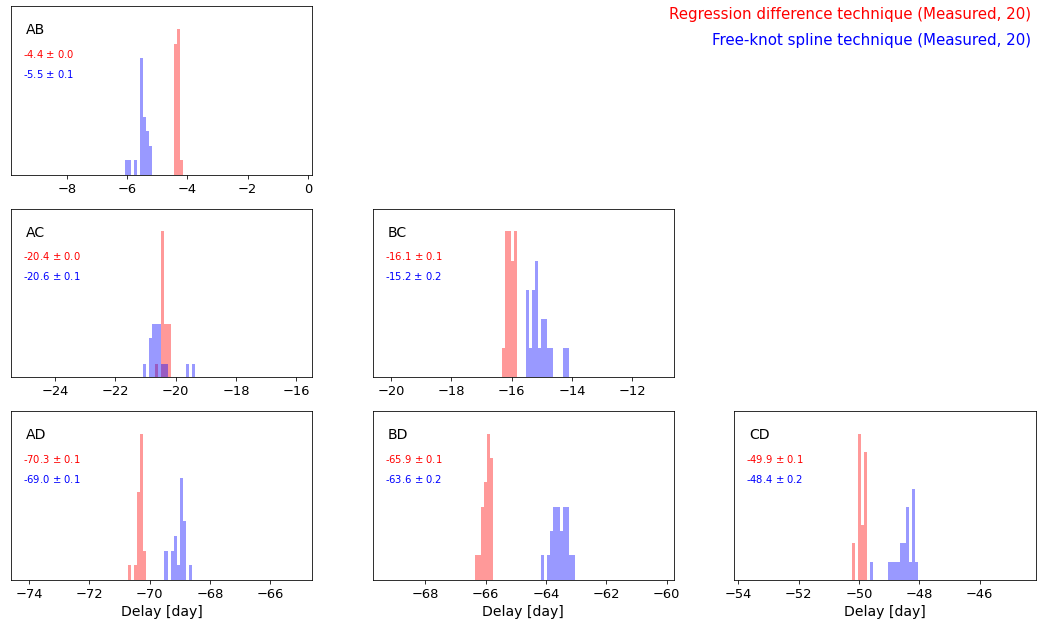

In [6]:
dataresults = [
    pycs3.sim.run.collect(directory =os.path.join(simfolder,"sims_copies_opt_reg"), plotcolour= "red", name="Regression difference technique"),
    pycs3.sim.run.collect(directory = os.path.join(simfolder,"sims_copies_opt_spl"),  plotcolour="blue", name="Free-knot spline technique")
]

pycs3.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False, dataout=True, usemedian=True, outdir=simfolder)

__Warning__ : The median of the distribution will be our central estimate of the time delays but the variance cannot be interpreted as the uncertainties on the time delay measurement as it reflect only the *intrinsic* variance of the estimator. And it should be very peaked ! A large *intrinsic* variance means that your data do not constrain well the time delays and there is not hope to obtain robust estimates. 

To properly estimate the uncertainties, we need to generate mock light curves with randomized noise. The central estimate is saved in the file `*_delays.pkl'`.

# Drawing mocks

We now generate mock light curves, built on the same intrinsic and extrinsic spline model than the data, but with randomized noise. We define the functions that control the small scale extrinsic variability, used to generated the synthetic curves. The `beta` and `sigma` paremeters can be adjusted to match the data properties in term of random and correlated noise (see [Tewes et al. 2013](https://arxiv.org/abs/1208.5598) for details). This procedure is now automatised by directly measuring the power spectrum in the residuals of the spline fit (see  [Millon et al. 2020](https://arxiv.org/abs/2002.05736) for details and this [script](../scripts/3a_generate_tweakml.py) for the implementation)

These functions are then used to generate mock curves, that are shifted in time by a random time shift chosen in the interval `truetsr` $\in [-10;+10]$ days around the measured delay. 

In [7]:
#The optimisation of the parameter is not demonstrated here, because it requires some heavy computation. 
#See script 3a for the details. Here, we just take the best fit values that have been computed on a cluster. 

def tweakml_PS_1(lcs, spline):
    return pycs3.sim.twk.tweakml_PS(lcs, spline, 0.16250000000000003, f_min=1 / 300.0, psplot=False, verbose=False,
                          interpolation='linear', A_correction=1.736335872520465)

def tweakml_PS_2(lcs, spline):
    return pycs3.sim.twk.tweakml_PS(lcs, spline, 0.16250000000000003, f_min=1 / 300.0, psplot=False, verbose=False,
                          interpolation='linear', A_correction=1.0763462852329042)

def tweakml_PS_3(lcs, spline):
    return pycs3.sim.twk.tweakml_PS(lcs, spline, 0.20000000000000004, f_min=1 / 300.0, psplot=False, verbose=False,
                          interpolation='linear', A_correction=1.044104906831302)

def tweakml_PS_4(lcs, spline):
    return pycs3.sim.twk.tweakml_PS(lcs, spline, 0.2750000000000001, f_min=1 / 300.0, psplot=False, verbose=False,
                          interpolation='linear', A_correction=0.9724197327004451)


pycs3.sim.draw.saveresiduals(lcs, spline) # necessary before drawing mocks
pycs3.sim.draw.multidraw(lcs, spline=spline, n=5, npkl=10, simset="mock",
                         truetsr=10.0, tweakml=[tweakml_PS_1, tweakml_PS_2, tweakml_PS_3, tweakml_PS_4], destpath=simfolder)


Now thowing dice into ./sim/sims_mock ...
Input shifts :
A    +1.68 | B    -3.95 | C   -19.46 | D   -67.55
Input delays :
AB =   -5.63 | AC =  -21.14 | AD =  -69.23 | BC =  -15.51 | BD =  -63.60 | CD =  -48.09
Drawing 5 simulations for pkl 1/10 ...
Wrote ./sim/sims_mock/1_1590746248.47801.pkl
Drawing 5 simulations for pkl 2/10 ...
Wrote ./sim/sims_mock/2_1590746249.61361.pkl
Drawing 5 simulations for pkl 3/10 ...
Wrote ./sim/sims_mock/3_1590746250.61932.pkl
Drawing 5 simulations for pkl 4/10 ...
Wrote ./sim/sims_mock/4_1590746251.57089.pkl
Drawing 5 simulations for pkl 5/10 ...
Wrote ./sim/sims_mock/5_1590746252.54054.pkl
Drawing 5 simulations for pkl 6/10 ...
Wrote ./sim/sims_mock/6_1590746253.59468.pkl
Drawing 5 simulations for pkl 7/10 ...
Wrote ./sim/sims_mock/7_1590746254.62923.pkl
Drawing 5 simulations for pkl 8/10 ...
Wrote ./sim/sims_mock/8_1590746255.76420.pkl
Drawing 5 simulations for pkl 9/10 ...
Wrote ./sim/sims_mock/9_1590746256.76611.pkl
Drawing 5 simulations for pkl 10/1

## Optimising the mock curves. 
We are now ready to optimize the curves and this can take some time...

In [8]:
success_dic = pycs3.sim.run.multirun("mock", lcs, spl, kwargs_optim_spl, optset="spl", tsrand=10.0, keepopt=True, destpath=simfolder, ncpu=1)
success_dic = pycs3.sim.run.multirun("mock", lcs, regdiff, kwargs_optim_reg, optset="reg", tsrand=10.0, keepopt=True, destpath=simfolder, ncpu=1)

I have found 10 simulation pickles in ./sim/sims_mock.
I'll write my results into the directory ./sim/sims_mock_opt_spl.
Initial conditions : 
[Trial/A](1.683,12.625,0)|~3/7l7b/5~|
[Trial/B](-3.951,11.978,0)|~3/7l7b/5~|
[Trial/C](-19.460,11.025,0)|~3/7l7b/5~|
[Trial/D](-67.547,10.532,0)|~3/7l7b/5~|
--- Casino running on simset mock, optset spl ---
Read ./sim/sims_mock/10_1590746257.87748.pkl
Working for ./sim/sims_mock_opt_spl/10_1590746257.87748_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...
Knot spacing min = 3.777137, epsilon = 10.000000
Shifted 4/5 simulations on 1/8 CPUs, time : 40
I failed for 1 curves.
remove simlcs  0
Wrote ./sim/sims_mock_opt_spl/10_1590746257.87748_opt.pkl
Wrote ./sim/sims_mock_opt_spl/10_1590746257.87748_runresults.pkl
--- Casino running on simset mock, optset spl ---
Read ./sim/sims_mock/1_1590746248.47801.pkl
Working for ./sim/sims_mock_opt_spl/1_1590746248.47801_runresults.pkl, 5 simulations.
Starting the

/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 13
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/1_1590746248.47801_opt.pkl
Wrote ./sim/sims_mock_opt_reg/1_1590746248.47801_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/2_1590746249.61361.pkl
Working for ./sim/sims_mock_opt_reg/2_1590746249.61361_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 13
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/2_1590746249.61361_opt.pkl
Wrote ./sim/sims_mock_opt_reg/2_1590746249.61361_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/3_1590746250.61932.pkl
Working for ./sim/sims_mock_opt_reg/3_1590746250.61932_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 14
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/3_1590746250.61932_opt.pkl
Wrote ./sim/sims_mock_opt_reg/3_1590746250.61932_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/4_1590746251.57089.pkl
Working for ./sim/sims_mock_opt_reg/4_1590746251.57089_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 15
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/4_1590746251.57089_opt.pkl
Wrote ./sim/sims_mock_opt_reg/4_1590746251.57089_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/5_1590746252.54054.pkl
Working for ./sim/sims_mock_opt_reg/5_1590746252.54054_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 15
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/5_1590746252.54054_opt.pkl
Wrote ./sim/sims_mock_opt_reg/5_1590746252.54054_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/6_1590746253.59468.pkl
Working for ./sim/sims_mock_opt_reg/6_1590746253.59468_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 15
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/6_1590746253.59468_opt.pkl
Wrote ./sim/sims_mock_opt_reg/6_1590746253.59468_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/7_1590746254.62923.pkl
Working for ./sim/sims_mock_opt_reg/7_1590746254.62923_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 14
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/7_1590746254.62923_opt.pkl
Wrote ./sim/sims_mock_opt_reg/7_1590746254.62923_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/8_1590746255.76420.pkl
Working for ./sim/sims_mock_opt_reg/8_1590746255.76420_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 14
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/8_1590746255.76420_opt.pkl
Wrote ./sim/sims_mock_opt_reg/8_1590746255.76420_runresults.pkl
--- Casino running on simset mock, optset reg ---
Read ./sim/sims_mock/9_1590746256.76611.pkl
Working for ./sim/sims_mock_opt_reg/9_1590746256.76611_runresults.pkl, 5 simulations.
Starting the curve shifting on a single CPU, no multiprocessing...


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


Shifted 5/5 simulations on 1/8 CPUs, time : 15
I failed for 0 curves.
Wrote ./sim/sims_mock_opt_reg/9_1590746256.76611_opt.pkl
Wrote ./sim/sims_mock_opt_reg/9_1590746256.76611_runresults.pkl


/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:138: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.tsarray = np.vstack(np.array([l.timeshift for l in lcs]) for lcs in lcslist)
/Users/martin/Desktop/modules/PyCS3/pycs3/sim/run.py:141: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.truetsarray = np.vstack(np.array([getattr(l, "truetimeshift", 0.0) for l in lcs]) for lcs in lcslist)


## Check the residuals statistics

In order to verify if the generative noise model was producing light curves with the same constraining power than the original data, we check that two statistics : the *normalized number of runs* `zruns` and the *standard deviation* `sigma` of the residuals are similar between the mock curves and the data (see [Tewes et al. 2013](https://arxiv.org/abs/1208.5598) for more details about these two metrics).

Analysing the residuals of simset mock
./sim/sims_mock_opt_spl/*_opt.pkl
We have 49 simulated curves
++++++ A ++++++
zruns : -3.46 (obs) vs -3.90 +/- 0.68 (sim)
sigma : 0.0116 (obs) vs 0.0099 +/- 0.0012 (sim)
++++++ B ++++++
zruns : -3.23 (obs) vs -3.90 +/- 0.58 (sim)
sigma : 0.0211 (obs) vs 0.0201 +/- 0.0023 (sim)
++++++ C ++++++
zruns : -3.07 (obs) vs -3.06 +/- 0.64 (sim)
sigma : 0.0279 (obs) vs 0.0280 +/- 0.0037 (sim)
++++++ D ++++++
zruns : -3.47 (obs) vs -3.22 +/- 0.65 (sim)
sigma : 0.0202 (obs) vs 0.0203 +/- 0.0024 (sim)


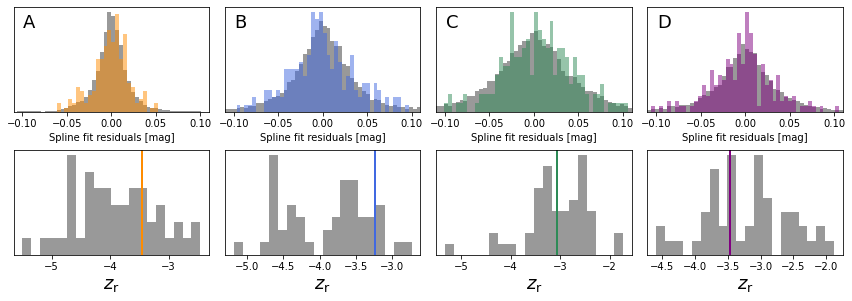

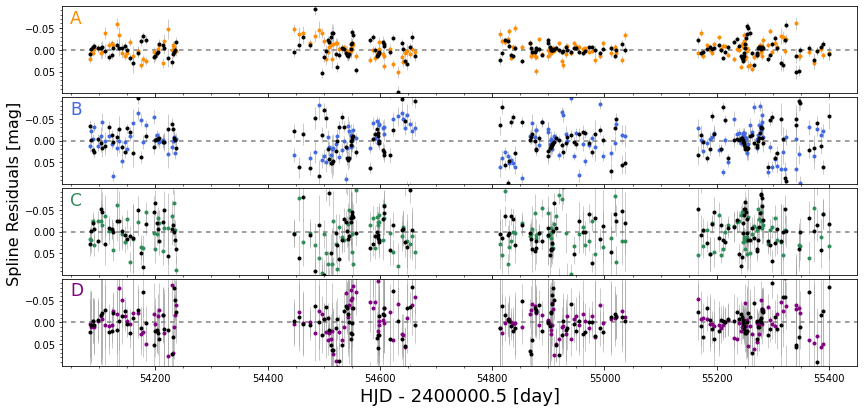

In [9]:
stats = pycs3.gen.stat.anaoptdrawn(lcs, spline, simset="mock", optset="spl", showplot=True,nplots=1,
                                    directory=simfolder)


## Collecting the results of the mocks

We now collect the results of the mocks to have an estimation of the uncertainties on the time delays. Normally, you will need at least 500 mock curves to have a robust estimate of the uncertainties. To obtain the final error, we compare the measured delay to the "true" input delay and we add in quadrature the random and systematic errors. The uncertainties are saved in the file `*_errorbars.pkl'`.


Reading 10 runresult pickles...
OK, I have collected 50 runs from Regression difference technique
Reading 10 runresult pickles...
OK, I have collected 49 runs from Free-knot spline technique
[-7.  3.]
[-23. -13.]
[-21. -11.]
[-72. -62.]
[-70. -60.]
[-54. -44.]
Wrote ./sim/sims_mock_opt_reg_errorbars.pkl
Wrote ./sim/sims_mock_opt_spl_errorbars.pkl


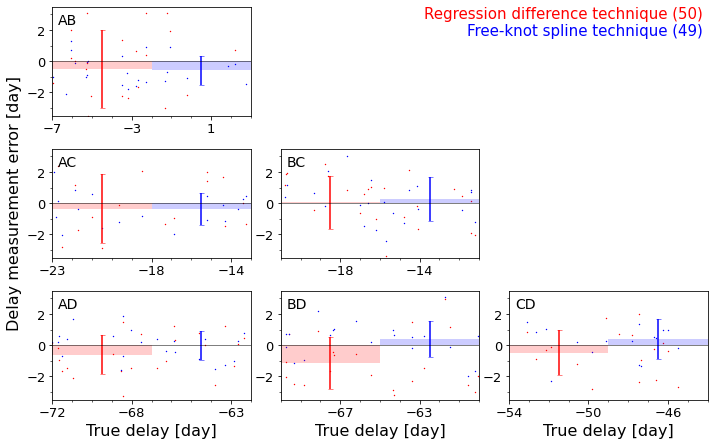

In [10]:
simresults = [
    pycs3.sim.run.collect(directory =os.path.join(simfolder,"sims_mock_opt_reg"), plotcolour= "red", name="Regression difference technique"),
    pycs3.sim.run.collect(directory =os.path.join(simfolder,"sims_mock_opt_spl"),  plotcolour="blue", name="Free-knot spline technique")
]

pycs3.sim.plot.measvstrue(simresults, errorrange=3.5, r=5.0, nbins = 1, binclip=True, 
                          binclipr=20.0,plotpoints=True, dataout=True, outdir='./sim/')

# Comibining estimators

We can now combine the free-kont spline and regression difference estimators. This is done with the `pycs3.mltd.comb` module. Note that the combination might not be very accurate when `testmode` is True, use `testmode=False` and increase the number of bins to ensure the numerical stability. 

Read ./sim/sims_copies_opt_reg_delays.pkl
Read ./sim/sims_mock_opt_reg_errorbars.pkl
Read ./sim/sims_copies_opt_spl_delays.pkl
Read ./sim/sims_mock_opt_spl_errorbars.pkl
**********
Regression Difference
Delay AB: -4.36 +/- 2.52  -->  -4.39 +2.52-2.52
Delay AC: -20.40 +/- 2.25  -->  -20.43 +2.24-2.24
Delay BC: -16.05 +/- 1.68  -->  -16.07 +1.68-1.68
Delay AD: -70.26 +/- 1.41  -->  -70.28 +1.40-1.40
Delay BD: -65.91 +/- 2.00  -->  -65.92 +2.00-2.00
Delay CD: -49.92 +/- 1.50  -->  -49.94 +1.48-1.50
**********
Free-knot Spline
Delay AB: -5.48 +/- 1.09  -->  -5.51 +1.08-1.08
Delay AC: -20.63 +/- 1.10  -->  -20.63 +1.08-1.12
Delay BC: -15.16 +/- 1.45  -->  -15.19 +1.44-1.44
Delay AD: -68.97 +/- 0.92  -->  -69.00 +0.92-0.92
Delay BD: -63.55 +/- 1.22  -->  -63.56 +1.20-1.24
Delay CD: -48.41 +/- 1.36  -->  -48.42 +1.36-1.36
=====Tension comparison=====
Reference is Free-knot Spline
---Regression Difference---
  AB: 0.41
  AC: 0.09
  BC: 0.40
  AD: 0.77
  BD: 1.00
  CD: 0.75
---Free-knot Spline-

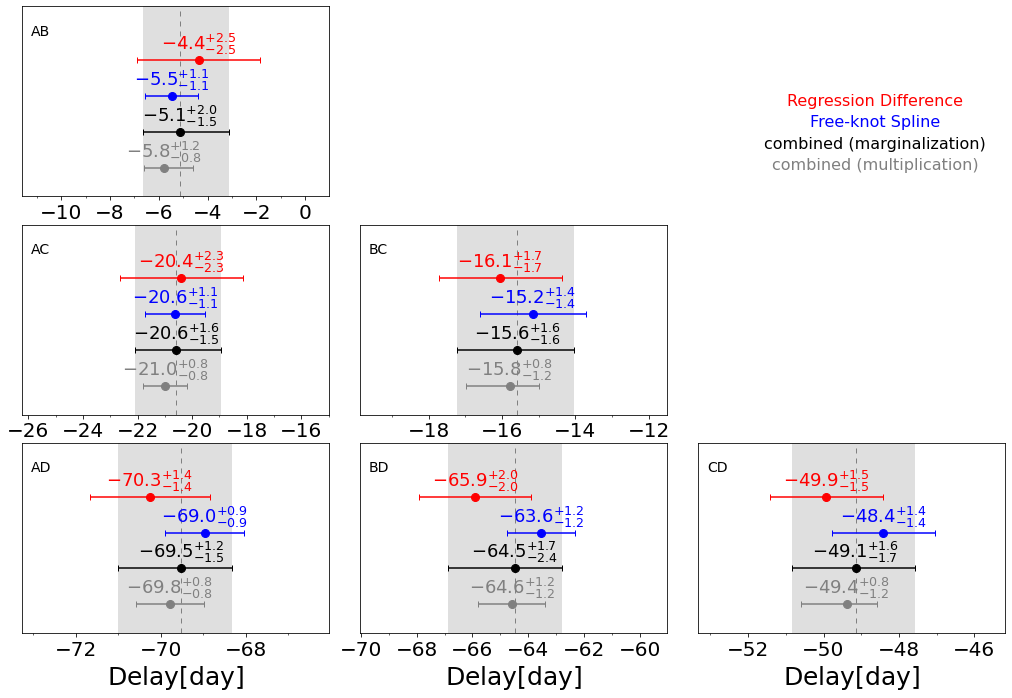

In [11]:
group_list = [pycs3.mltd.comb.getresults(
                    pycs3.mltd.comb.CScontainer("Regression Difference",
                                                result_file_delays=os.path.join(simfolder,'sims_copies_opt_reg_delays.pkl'),
                                                result_file_errorbars=os.path.join(simfolder,'sims_mock_opt_reg_errorbars.pkl'),
                                                colour = 'red')), 
             pycs3.mltd.comb.getresults(
                    pycs3.mltd.comb.CScontainer("Free-knot Spline",
                                                result_file_delays=os.path.join(simfolder,'sims_copies_opt_spl_delays.pkl'),
                                                result_file_errorbars=os.path.join(simfolder,'sims_mock_opt_spl_errorbars.pkl'),
                                                colour = 'blue'))]
testmode = False #to ensure fast computation
nbins = 5000 

#linearize the distribution : 
binslist = [np.linspace(-100,100,nbins) for i in range(6)] #we provide the bins to compute the distribution, one array per delay.
for g, group in enumerate(group_list):
    group.binslist = binslist
    group.linearize(testmode=testmode)

#compute the combined estimate : 
combined = pycs3.mltd.comb.combine_estimates(group_list, sigmathresh=0.0, testmode=testmode)
combined.linearize(testmode=testmode)
combined.name = 'combined (marginalization)'
combined.plotcolor = 'black'

mult = pycs3.mltd.comb.mult_estimates(group_list)
mult.name = "combined (multiplication)"
mult.plotcolor = "gray"

pycs3.mltd.plot.delayplot(group_list + [combined] + [mult], rplot=10, refgroup=combined, hidedetails=True,
                                  showbias=False, showran=False, showlegend=True, figsize=(15, 10),
                                  horizontaldisplay=False, legendfromrefgroup=False, auto_radius=True,
                                  tick_step_auto=True)

We recommand to marginalize over the two estimators and not to multiply the probability distribution. This is because the two estimators cannot be considered as independent since they are applied to the same data set. Also, remember to test other combinations of estimator parameters (e.g.,`knotstep` and `mlknotstep` for the splines). If this is changing the time delays but still provide a good fit to the data, it is necessary to marginalize over the estimator parameters. 